We want to try different neural networks for time series forecasting. This are simple neural networks (NN) and recurring NN (RNN), from which specifically we experiment with Gate Recurrent Unit (GRU) and Long Short-Term Memory (LSTM).

2025-03-31 12:15:40.234493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 12:15:40.258352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 12:15:40.287803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 12:15:40.297285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 12:15:40.320608: I tensorflow/core/platform/cpu_feature_guar

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


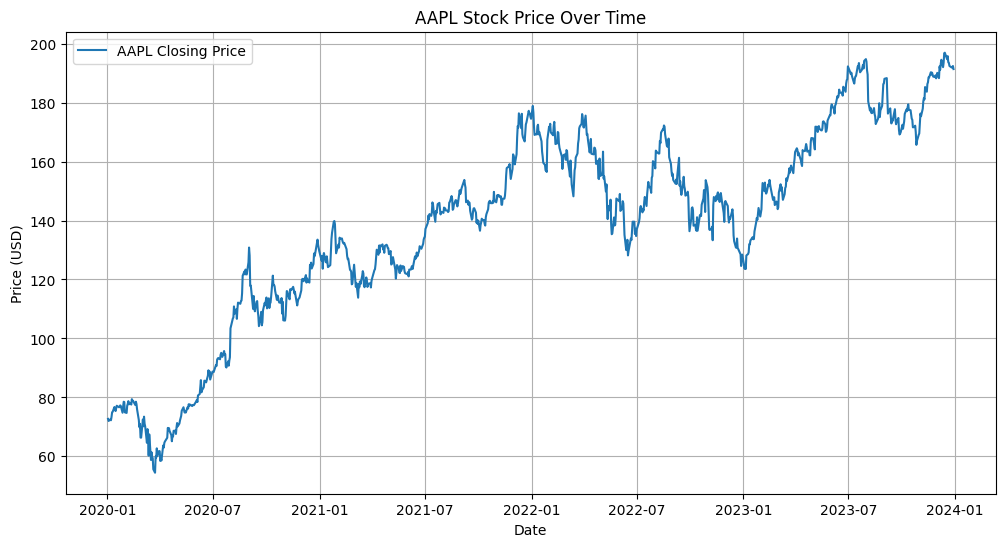

In [1]:
# the example
import yfinance as yf  # Yahoo Finance for historical stock data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Flatten

# Fetch stock data
ticker = "AAPL"  # Change to any stock symbol you like
start_date = "2020-01-01"
end_date = "2024-01-01"
data = yf.download(ticker, start=start_date, end=end_date)

# Use only the 'Close' column
data = data[['Close']]

# Ensure the data is sorted by date
data = data.sort_index()

# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

We train the models on all the available days minus the last 10 and check how they perform in predicting these. Prepare the data:

In [2]:
# Scale the data in [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close']])

# Create sequences for models; these are lag features
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        # append the #seq_length lags for data[i+seq_length]; input
        sequences.append(data[i:i+seq_length])
        # add the target value of data[i+seq_length]; output
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# number of lags to be included
seq_length = 5
X, y = create_sequences(data_scaled, seq_length)# input, output

# remove the last days days from the training set; well check predictions on them
train_size = int(len(X) - 10)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

LSTM, GRU and simple sequentil NN models with Keras:

In [3]:
# Train the LSTM model
print("Training LSTM model...")
# Define the LSTM model
lstm_model = Sequential([
    #LSTM(20, return_sequences=True, input_shape=(seq_length, 1)),
    #Dropout(0.2),
    #LSTM(10),
    #Dense(1)
    #LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    #Dropout(0.2),
    #LSTM(30, return_sequences=True, input_shape=(seq_length, 1)),
    #Dropout(0.2),
    LSTM(10, return_sequences=False, input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
# train the model
lstm_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1)

# Make predictions with the LSTM model
# apply trained model on training data
lstm_train_preds = lstm_model.predict(X_train)

# Make future predictions with the LSTM model
# the 1st prediction needs to be used to generate the future lags and roll them over
lstm_rolling_preds = []

# Start with the last sequence from the test set
lstm_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match LSTM input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = lstm_model.predict(lstm_current_sequence, verbose=0)[0, 0]
    lstm_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    lstm_current_sequence = np.roll(lstm_current_sequence, -1, axis=1)
    lstm_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
lstm_test_preds = scaler.inverse_transform(np.array(lstm_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
lstm_train_preds = scaler.inverse_transform(lstm_train_preds)

###########################################################################################
# Train the GRU model
print("Training GRU model...")
# Define the GRU model
gru_model = Sequential([
    GRU(10, return_sequences=False, input_shape=(seq_length, 1)),  # GRU layer with 10 units
    Dense(1)  # Output layer
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1)

# Make predictions with the GRU model
# Apply trained model on training data
gru_train_preds = gru_model.predict(X_train)

# Make future predictions with the GRU model
gru_rolling_preds = []

# Start with the last sequence from the test set
gru_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match GRU input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = gru_model.predict(gru_current_sequence, verbose=0)[0, 0]
    gru_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    gru_current_sequence = np.roll(gru_current_sequence, -1, axis=1)
    gru_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
gru_test_preds = scaler.inverse_transform(np.array(gru_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
gru_train_preds = scaler.inverse_transform(gru_train_preds)

# Train the Simple Sequential Neural Network
nn_model = Sequential([
    Flatten(input_shape=(seq_length, 1)),  # Flatten the input sequence
    Dense(10, activation='relu'),  # Fully connected layer with 10 neurons
    Dense(1)  # Output layer
])
nn_model.compile(optimizer='adam', loss='mse')

###########################################################################################
# Train the NN model
print("Training NN model...")
# Define the NN model
nn_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1)

# Make predictions with the NN model
# Apply trained model on training data
nn_train_preds = nn_model.predict(X_train)

# Make future predictions with the NN model
nn_rolling_preds = []

# Start with the last sequence from the test set
nn_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match NN input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = nn_model.predict(nn_current_sequence, verbose=0)[0, 0]
    nn_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    nn_current_sequence = np.roll(nn_current_sequence, -1, axis=1)
    nn_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
nn_test_preds = scaler.inverse_transform(np.array(nn_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
nn_train_preds = scaler.inverse_transform(nn_train_preds)

# inverse transform targets for plots later
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Training LSTM model...


2025-03-31 12:15:43.816833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-31 12:15:43.816913: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: Dobby
2025-03-31 12:15:43.816924: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: Dobby
2025-03-31 12:15:43.817233: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 560.35.3
2025-03-31 12:15:43.817289: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  560.35.03  Release Build  (dvs-builder@U16-I1-N07-12-3)  Fri Aug 16 21:42:42 UTC 2024
GCC version:  gcc version 12.3.0 (Ubuntu 12.3.0-1ubuntu1~22.04) 

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3030
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2140
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1175
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0423
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038
Epoch 15/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032
Epoch

/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1948
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0819
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0231
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 15/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 16/40
16/

/home/thanasis/anaconda3/envs/market_forecasting_ml_py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077  
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
Epoch 15/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 16/40
16/16 ━━━

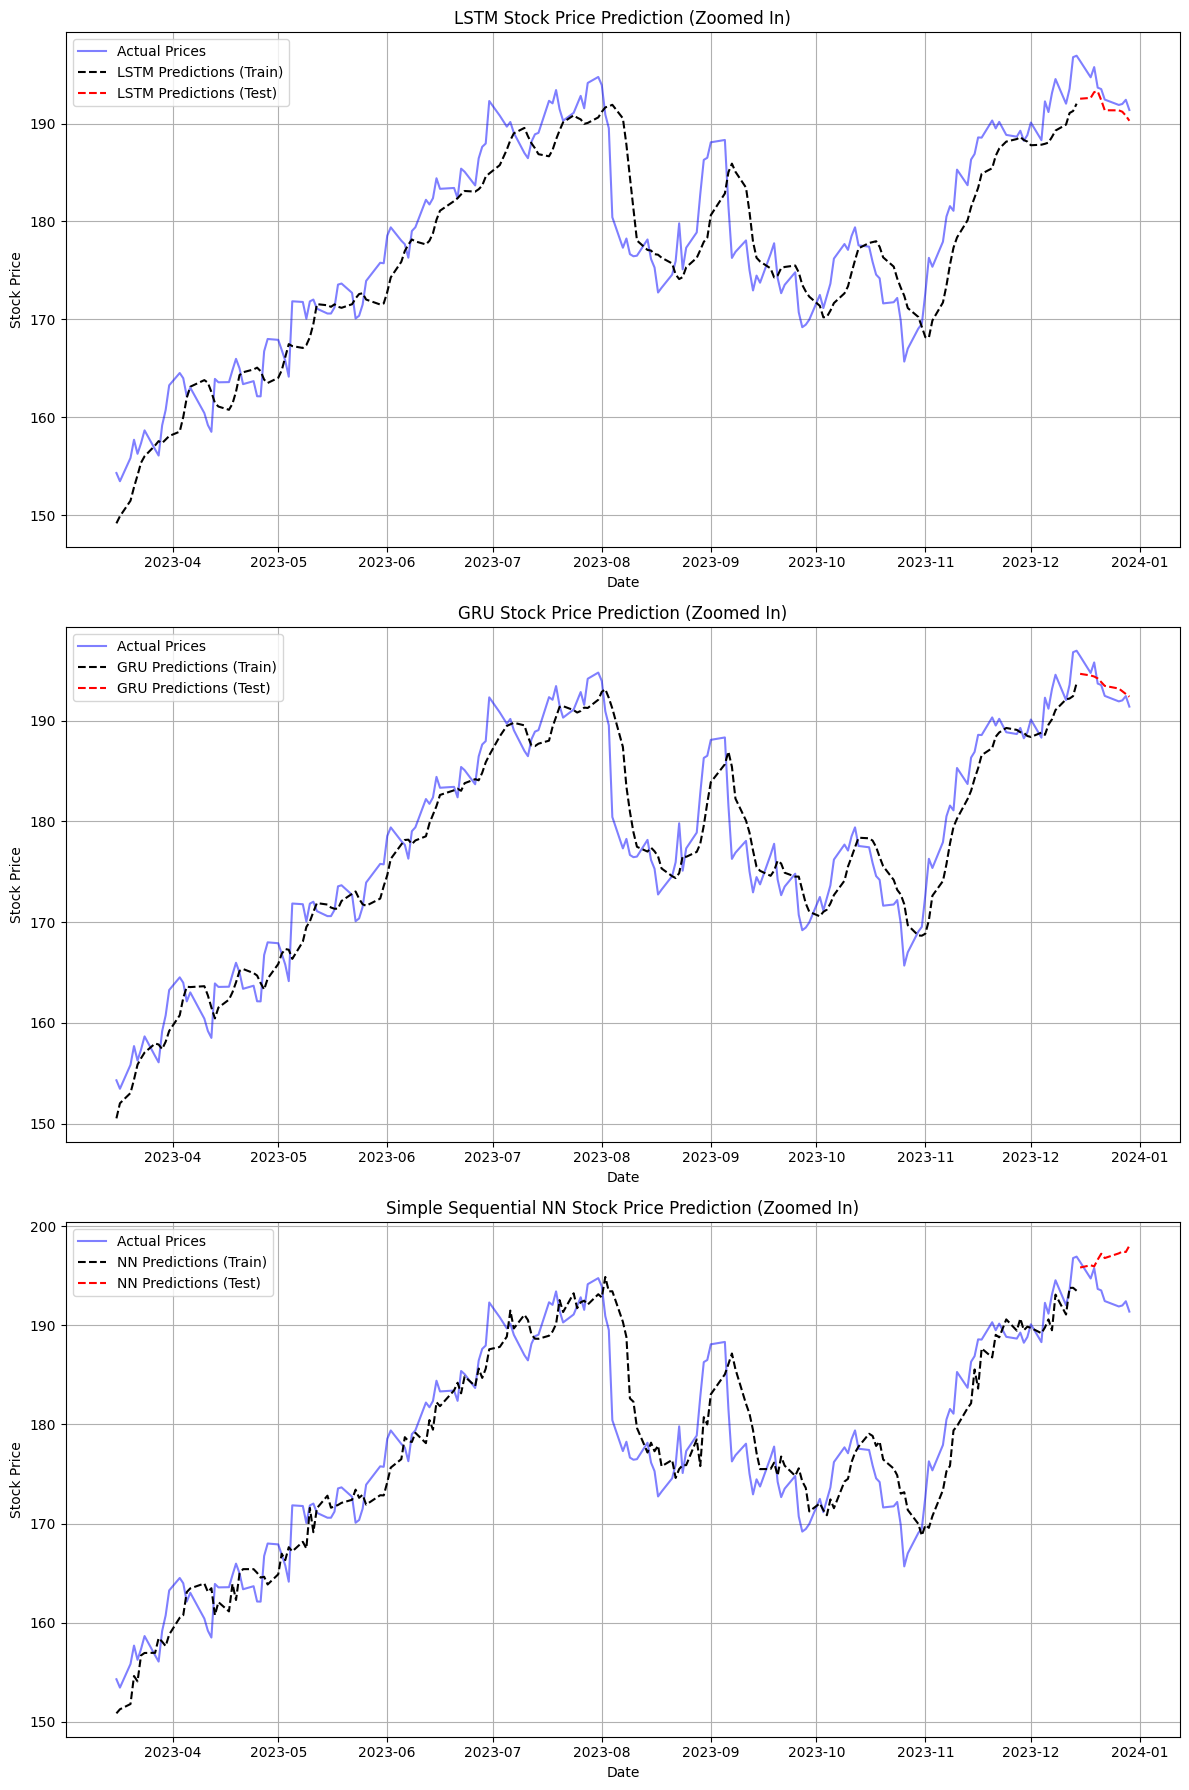

LSTM RMSE (Train): 4.25
LSTM RMSE (Test): 1.82
GRU RMSE (Train): 3.30
GRU RMSE (Test): 0.99
NN RMSE (Train): 3.91
NN RMSE (Test): 4.13


In [4]:
# Define zoom-in indices
i = -200  # Start index for zooming (e.g., last 100 points)
j = None  # End index for zooming (use None for the end of the data)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows, 1 column

# Plot LSTM results
axes[0].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[0].plot(data.index[seq_length:train_size+seq_length][i+10:j], lstm_train_preds[i+10:j], label="LSTM Predictions (Train)", color="black", linestyle="--")
axes[0].plot(data.index[train_size+seq_length:][i:j], lstm_test_preds[i:j], label="LSTM Predictions (Test)", color="red", linestyle="--")
axes[0].legend()
axes[0].set_title("LSTM Stock Price Prediction (Zoomed In)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Stock Price")
axes[0].grid(True)

# Plot GRU results
axes[1].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[1].plot(data.index[seq_length:train_size+seq_length][i+10:j], gru_train_preds[i+10:j], label="GRU Predictions (Train)", color="black", linestyle="--")
axes[1].plot(data.index[train_size+seq_length:][i:j], gru_test_preds[i:j], label="GRU Predictions (Test)", color="red", linestyle="--")
axes[1].legend()
axes[1].set_title("GRU Stock Price Prediction (Zoomed In)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Stock Price")
axes[1].grid(True)

# Plot Simple Sequential NN results
axes[2].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[2].plot(data.index[seq_length:train_size+seq_length][i+10:j], nn_train_preds[i+10:j], label="NN Predictions (Train)", color="black", linestyle="--")
axes[2].plot(data.index[train_size+seq_length:][i:j], nn_test_preds[i:j], label="NN Predictions (Test)", color="red", linestyle="--")
axes[2].legend()
axes[2].set_title("Simple Sequential NN Stock Price Prediction (Zoomed In)")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Stock Price")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Evaluate and print RMSE for all models
lstm_train_rmse = np.sqrt(mean_squared_error(y_train, lstm_train_preds))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_preds))
print(f"LSTM RMSE (Train): {lstm_train_rmse:.2f}")
print(f"LSTM RMSE (Test): {lstm_test_rmse:.2f}")

gru_train_rmse = np.sqrt(mean_squared_error(y_train, gru_train_preds))
gru_test_rmse = np.sqrt(mean_squared_error(y_test, gru_test_preds))
print(f"GRU RMSE (Train): {gru_train_rmse:.2f}")
print(f"GRU RMSE (Test): {gru_test_rmse:.2f}")

nn_train_rmse = np.sqrt(mean_squared_error(y_train, nn_train_preds))
nn_test_rmse = np.sqrt(mean_squared_error(y_test, nn_test_preds))
print(f"NN RMSE (Train): {nn_train_rmse:.2f}")
print(f"NN RMSE (Test): {nn_test_rmse:.2f}")